In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from itertools import product
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
from sklearn.preprocessing import MinMaxScaler
import anfis
from anfis.anfis import ANFIS
import torch.nn as nn
from anfis.membership import membershipfunction
from anfis.anfis import predict

In [111]:
# HW2---data
# bankruptcy_aveLinkage.csv
# bankruptcy_completeLinkage.csv
# bankruptcy_fuzzy.csv
# bankruptcy_kmeans.csv
# bankruptcy_sigleLinkage.csv
# diamonds_aveLinkage.csv
# diamonds_completeLinkage.csv
# diamonds_fuzzy.csv
# diamonds_kmeans.csv
# diamonds_sigleLinkage.csv
file_path = 'bankruptcy_kmeans.csv'
df = pd.read_csv(file_path)
# df['price'] = np.log1p(df['price'])
sample_df = df.sample(frac=0.1, random_state=42)
print(f"original num of data: {len(df)}")
print(f"num of samples: {len(sample_df)}")
print(sample_df.head())

original num of data: 13198
num of samples: 1320
        ROA(C) before interest and depreciation before interest  \
5665                                            0.441671          
9124                                            0.453256          
5163                                            0.715351          
12654                                           0.431630          
9515                                            0.347878          

        Pre-tax net Interest Rate   After-tax net Interest Rate  \
5665                     0.797231                      0.809150   
9124                     0.797142                      0.809081   
5163                     0.797736                      0.809620   
12654                    0.797176                      0.809125   
9515                     0.795874                      0.807888   

        Continuous interest rate (after tax)  \
5665                                0.781410   
9124                                0.781359   
5

=== Step 1: Prepare Data ===

In [112]:
features = sample_df.select_dtypes(include=[np.number]).copy()
label_col = 'Bankrupt?' if 'Bankrupt?' in sample_df.columns else features.columns[-1]
# label_col = 'price' if 'price' in sample_df.columns else features.columns[-1]

exclude_cols = [label_col, 'KMeans Cluster'] if 'KMeans Cluster' in features.columns else [label_col]
corr_source = features.drop(columns=exclude_cols)

correlations = corr_source.corrwith(features[label_col]).abs().sort_values(ascending=False)
selected_feature_names = correlations.head(5).index.tolist()
print("Selected Features:", selected_feature_names)

X_raw = features[selected_feature_names]
y_raw = features[label_col]

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X = scaler_x.fit_transform(X_raw.values).astype(np.float32)
y = scaler_y.fit_transform(y_raw.values.reshape(-1, 1)).astype(np.float32)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)
print(f"total num of samples: {len(sample_df)}")
print(f"num of training samples: {len(X_train)}")
print(f"num of validation samples: {len(X_val)}")

Selected Features: [' ROA(C) before interest and depreciation before interest', ' Net Income to Total Assets', ' Retained Earnings to Total Assets', ' Borrowing dependency', " Net Income to Stockholder's Equity"]
total num of samples: 1320
num of training samples: 924
num of validation samples: 396


=== Step 2: Generate MF Parameters from Cluster ===

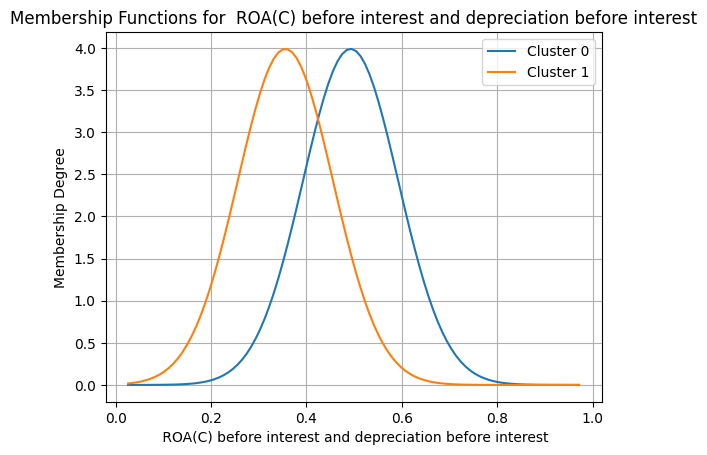

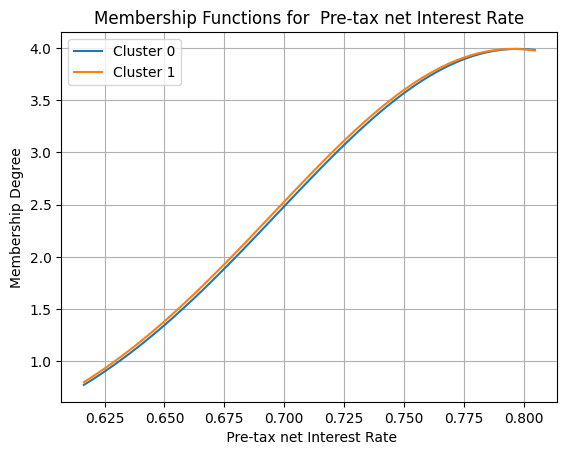

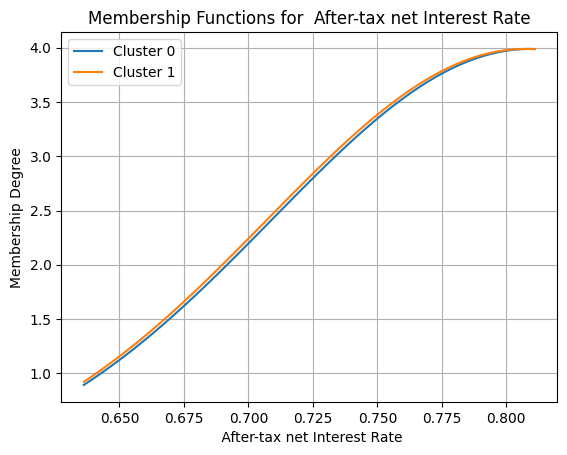

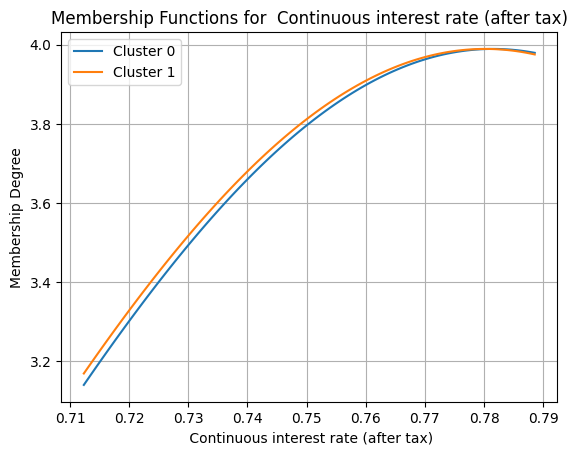

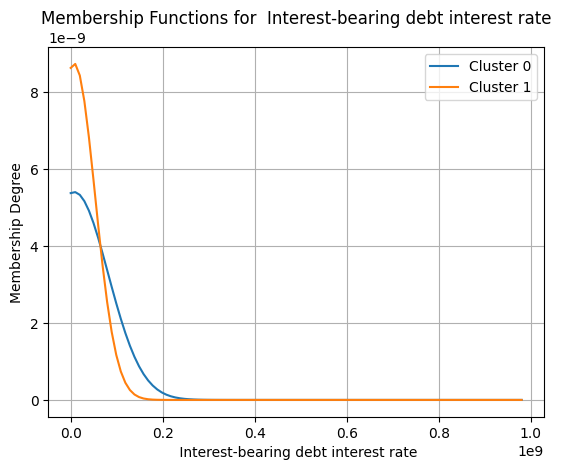

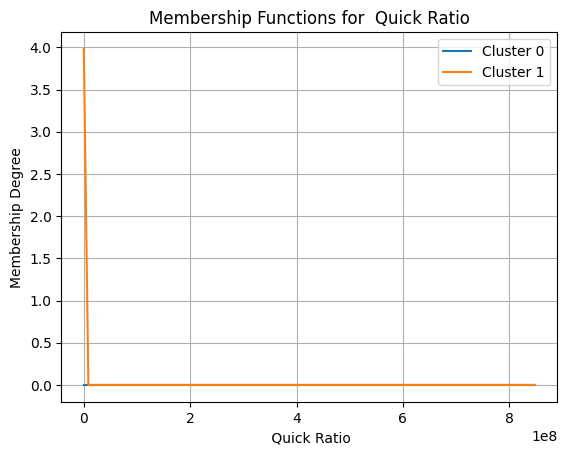

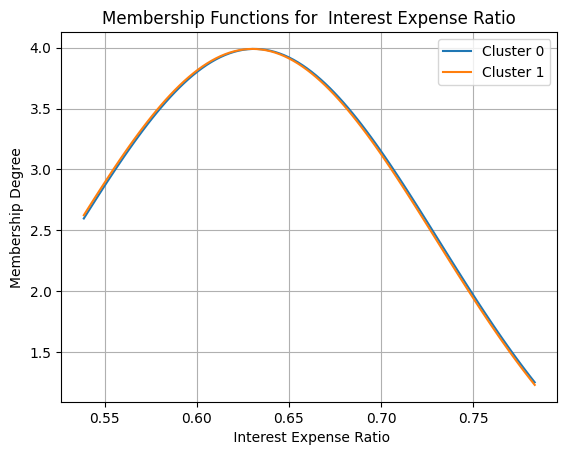

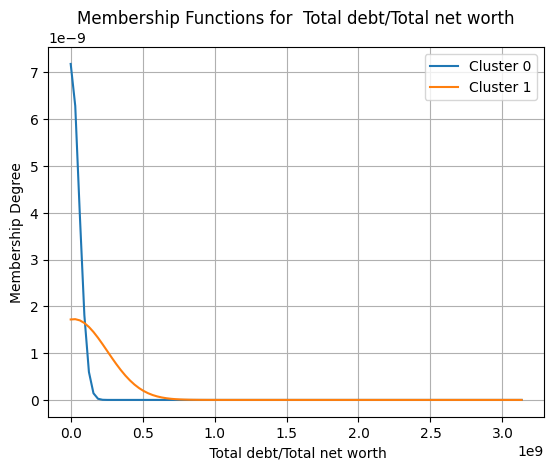

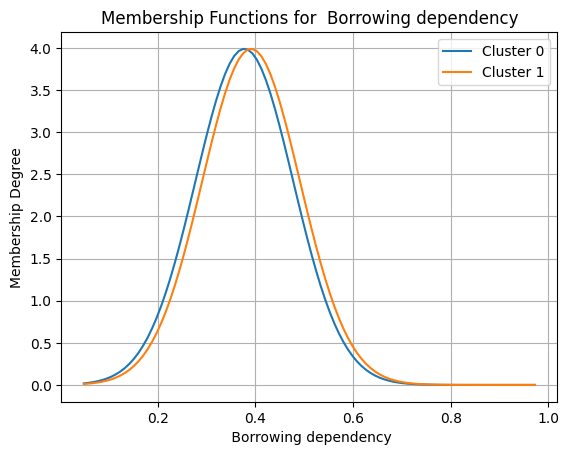

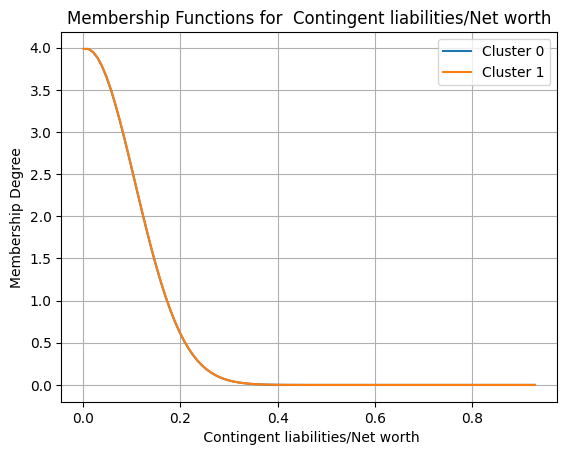

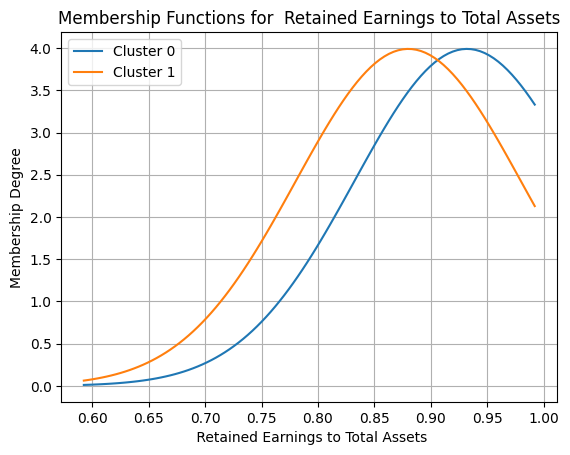

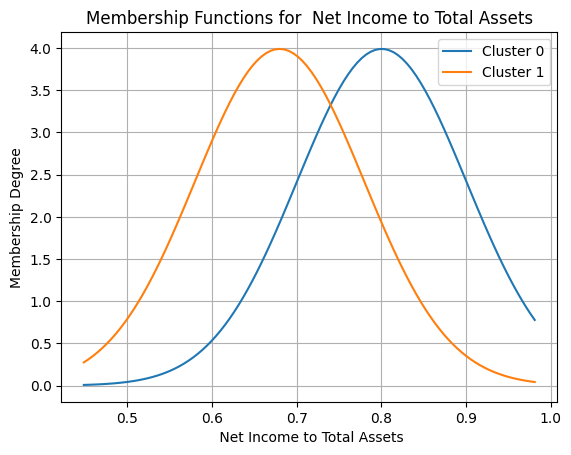

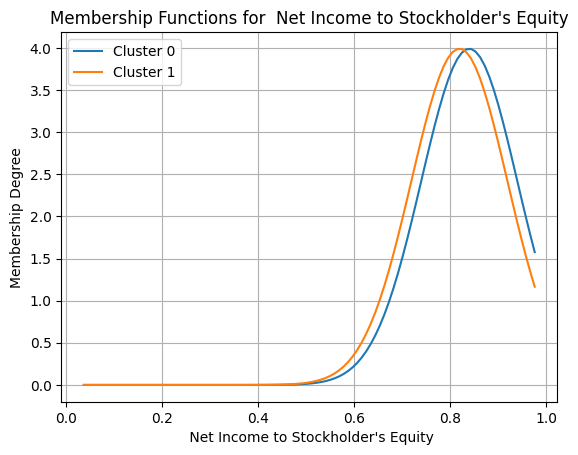

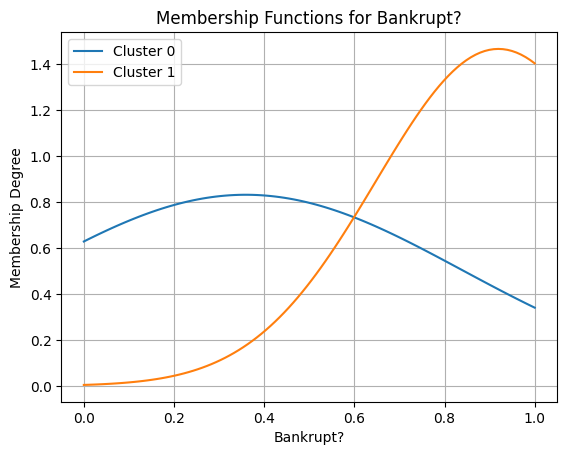


Variable:  ROA(C) before interest and depreciation before interest
  Cluster 1: mean = 0.493, std = 0.100
  Cluster 2: mean = 0.356, std = 0.100

Variable:  Pre-tax net Interest Rate
  Cluster 1: mean = 0.797, std = 0.100
  Cluster 2: mean = 0.796, std = 0.100

Variable:  After-tax net Interest Rate
  Cluster 1: mean = 0.809, std = 0.100
  Cluster 2: mean = 0.807, std = 0.100

Variable:  Continuous interest rate (after tax)
  Cluster 1: mean = 0.782, std = 0.100
  Cluster 2: mean = 0.780, std = 0.100

Variable:  Interest-bearing debt interest rate
  Cluster 1: mean = 7565885.502, std = 73857679.247
  Cluster 2: mean = 7469944.924, std = 45636681.413

Variable:  Quick Ratio
  Cluster 1: mean = 818532.827, std = 26333359.720
  Cluster 2: mean = 0.006, std = 0.100

Variable:  Interest Expense Ratio
  Cluster 1: mean = 0.631, std = 0.100
  Cluster 2: mean = 0.630, std = 0.100

Variable:  Total debt/Total net worth
  Cluster 1: mean = 2824740.990, std = 55492241.062
  Cluster 2: mean = 222

In [113]:
n_clusters = 2
membership_params = {}
cluster_label_col = 'KMeans Cluster'

for column in features.columns:
    if column == cluster_label_col:
        continue  # 跳過 clustering label 本身
    cluster_params = []
    for cluster_id in range(n_clusters):
        cluster_values = sample_df[sample_df[cluster_label_col] == cluster_id][column].dropna()
        if len(cluster_values) == 0:
            mean, std = 0.0, 1.0
        else:
            mean = np.mean(cluster_values)
            std = np.std(cluster_values)
            if std < 0.1:
                std = 0.1
        cluster_params.append({'mean': mean, 'std': std})
    membership_params[column] = cluster_params
    
    x_range = np.linspace(sample_df[column].min(), sample_df[column].max(), 100)
    for i, c in enumerate(cluster_params):
        y = norm.pdf(x_range, loc=c['mean'], scale=c['std'])
        plt.plot(x_range, y, label=f"Cluster {i}")
    plt.title(f"Membership Functions for {column}")
    plt.xlabel(column)
    plt.ylabel("Membership Degree")
    plt.legend()
    plt.grid(True)
    plt.show()

for var, funcs in membership_params.items():
    print(f"\nVariable: {var}")
    for i, f in enumerate(funcs):
        print(f"  Cluster {i+1}: mean = {f['mean']:.3f}, std = {f['std']:.3f}")

建立模糊推論規則組合

(根據 X_raw.columns 構建 mf_defs（保證順序與訓練資料一致）)

In [114]:
import numpy as np

num_features = X_train.shape[1]
num_mfs = 3  # 每個特徵設 3 個 MF
mf_defs = []

for i in range(num_features):
    min_val = X_train[:, i].min()
    max_val = X_train[:, i].max()
    means = np.linspace(min_val, max_val, num_mfs)
    std = (max_val - min_val) / (num_mfs * 1.5)
    stds = [max(std, 0.1)] * num_mfs  # 保證 std 不會太小
    mf_defs.append(list(zip(means, stds)))

In [115]:
for i, mf in enumerate(mf_defs):
    print(f"Feature {i} MFs:")
    for mean, std in mf:
        print(f"  mean = {mean:.3f}, std = {std:.3f}")

Feature 0 MFs:
  mean = 0.041, std = 0.213
  mean = 0.520, std = 0.213
  mean = 1.000, std = 0.213
Feature 1 MFs:
  mean = 0.000, std = 0.222
  mean = 0.500, std = 0.222
  mean = 1.000, std = 0.222
Feature 2 MFs:
  mean = 0.000, std = 0.222
  mean = 0.500, std = 0.222
  mean = 1.000, std = 0.222
Feature 3 MFs:
  mean = 0.000, std = 0.222
  mean = 0.500, std = 0.222
  mean = 1.000, std = 0.222
Feature 4 MFs:
  mean = 0.000, std = 0.221
  mean = 0.496, std = 0.221
  mean = 0.993, std = 0.221


In [116]:
print(anfis.__file__)

/home/anywhere2080ti/miniconda3/lib/python3.13/site-packages/anfis/__init__.py


=== Step 3: Initialize ANFIS Model ===

In [117]:
mf_defs_for_anfis = [
    [('gaussmf', {'mean': mean, 'sigma': std}) for (mean, std) in feature_mfs]
    for feature_mfs in mf_defs
]
mfc = membershipfunction.MemFuncs(mf_defs_for_anfis)

for i in range(3):
    print(f"Sample {i} MF activations:")
    print(mfc.evaluateMF(X_train[i]))
model = ANFIS(X_train, y_train, mfc)
model.trainHybridJangOffLine(epochs=20)

Sample 0 MF activations:
[[np.float32(0.11310633), np.float32(0.98692966), np.float32(0.054509178)], [np.float32(0.013287957), np.float32(0.7883303), np.float32(0.29603451)], [np.float32(0.0006845774), np.float32(0.29271644), np.float32(0.7922382)], [np.float32(0.2546749), np.float32(0.8372432), np.float32(0.017422138)], [np.float32(0.00055010046), np.float32(0.26732105), np.float32(0.8222586)]]
Sample 1 MF activations:
[[np.float32(0.11373599), np.float32(0.98650026), np.float32(0.054160226)], [np.float32(0.009430664), np.float32(0.72376025), np.float32(0.35158587)], [np.float32(0.00052782043), np.float32(0.26271847), np.float32(0.827712)], [np.float32(0.28813943), np.float32(0.7976355), np.float32(0.013976237)], [np.float32(0.00054018205), np.float32(0.26528794), np.float32(0.8246674)]]
Sample 2 MF activations:
[[np.float32(0.25841266), np.float32(0.8328144), np.float32(0.016988968)], [np.float32(0.03033906), np.float32(0.9253245), np.float32(0.17863654)], [np.float32(0.0011168483), 

array([[ 5.99665065e-01],
       [ 1.16955243e-01],
       [ 5.47864515e-01],
       [ 5.46916263e-01],
       [ 5.94297108e-01],
       [ 1.50783611e-01],
       [-5.26330065e-02],
       [-2.99607570e-02],
       [ 9.13638546e-01],
       [ 2.04856961e-01],
       [ 6.05753670e-01],
       [ 8.10125316e-01],
       [-1.48927496e-01],
       [-9.28151432e-02],
       [ 3.36287736e-02],
       [ 1.58582307e-02],
       [ 4.00225552e-01],
       [ 7.37869816e-01],
       [ 8.45643603e-01],
       [ 6.81334772e-01],
       [ 9.72059209e-01],
       [ 3.64574294e-01],
       [ 2.93609423e-01],
       [ 5.39472207e-01],
       [-6.58302708e-02],
       [-9.73836144e-02],
       [ 9.21941502e-01],
       [ 7.33432141e-01],
       [ 9.66435065e-02],
       [ 5.56223865e-01],
       [ 1.04051643e+00],
       [-1.74813434e-02],
       [-8.68575179e-02],
       [ 2.16183694e-01],
       [ 4.96319868e-01],
       [-3.44495336e-02],
       [ 6.80486078e-01],
       [ 9.88031130e-02],
       [-4.8

In [118]:
y_pred = predict(model, X_train)
print("First 5 predicted:", y_pred[:5])
print("First 5 inputs:", X_train[:5])
print("First 5 layerFour rows:", model.fittedValues[:5])

First 5 predicted: [[0.59966507]
 [0.11695524]
 [0.54786452]
 [0.54691626]
 [0.59429711]]
First 5 inputs: [[0.48587984 0.65326506 0.8483366  0.3675434  0.85493284]
 [0.48531273 0.67869073 0.86334145 0.35056368 0.8559685 ]
 [0.39153168 0.5875515  0.819349   0.34873787 0.85253835]
 [0.4300443  0.60567576 0.7807318  0.35053337 0.8528848 ]
 [0.45266414 0.6324697  0.8416056  0.36327562 0.85373217]]
First 5 layerFour rows: [[0.59966507]
 [0.11695524]
 [0.54786452]
 [0.54691626]
 [0.59429711]]


In [119]:
def evaluate_model(model, X_true, y_true, scaler_y=None, task='both'):
    y_pred = predict(model, X_true)

    if scaler_y is not None:
        y_pred = scaler_y.inverse_transform(y_pred)
        y_true = scaler_y.inverse_transform(y_true)

    # flatten
    y_pred = y_pred.flatten()
    y_true = y_true.flatten()

    # print("\n=== Regression Metrics ===")
    # if task in ['both', 'regression']:
    #     mse = mean_squared_error(y_true, y_pred)
    #     rmse = np.sqrt(mse)
    #     nrmse = rmse / (np.max(y_true) - np.min(y_true))
    #     mape = np.mean(np.clip(
    #         np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-6, None)) * 100,
    #         0, 100
    #     ))

    #     print(f"MSE   : {mse:.4f}")
    #     print(f"RMSE  : {rmse:.4f}")
    #     print(f"NRMSE : {nrmse:.4f}")
    #     print(f"MAPE  : {mape:.2f}%")

    print("\n=== Classification Metrics ===")
    if task in ['both', 'classification']:
        y_pred_bin = (y_pred > 0.5).astype(int)
        y_true_bin = (y_true > 0.5).astype(int)

        acc = accuracy_score(y_true_bin, y_pred_bin)
        rec = recall_score(y_true_bin, y_pred_bin)
        pre = precision_score(y_true_bin, y_pred_bin)
        f1 = f1_score(y_true_bin, y_pred_bin)

        print(f"Accuracy : {acc:.4f}")
        print(f"Recall   : {rec:.4f}")
        print(f"Precision: {pre:.4f}")
        print(f"F1-score : {f1:.4f}")

In [120]:
evaluate_model(model, X_train, y_train, scaler_y=scaler_y)
evaluate_model(model, X_val, y_val, scaler_y=scaler_y)


=== Classification Metrics ===
Accuracy : 0.8626
Recall   : 0.8515
Precision: 0.8535
F1-score : 0.8525

=== Classification Metrics ===
Accuracy : 0.8763
Recall   : 0.8614
Precision: 0.8923
F1-score : 0.8766
